In [218]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm
import multiprocessing

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()

import sys
sys.path.append(".")
from src.dc_smc import dc_smc 
from src.model import Model
from src.utils import resample, weighted_sum

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 5-var model

Target:
$$
y_i | x_i \sim \mathcal{N}(x_i, \sigma^2), i = 1, 2, 3 \\
x_i | x_4 \sim \mathcal{N}(x_4, \tau^2), i = 1, 2 \\
x_i | x_5 \sim \mathcal{N}(x_t, \gamma^2), i = 3, 4
$$
Priors:
$$
x_i \sim \mathcal{N}(\mu_0, \sigma_0^2), i = 1, 2, \ldots, 5
$$

In [231]:
tf.random.set_seed(1)

N = 2000 # num params samples
nobs = 1000 # num observations

sigma, tau, gamma = np.array([1.]), np.array([1.]), np.array([1.])
mu0, sigma0 = np.array([0.]), np.array([1.])

x5 = np.array([-1.])
x4, x3 = tfd.Normal(loc=x5, scale=gamma).sample(2)
x1, x2 = tfd.Normal(loc=x4, scale=tau).sample(2)
x_true = tf.reshape(tf.concat([x1, x2, x3, x4, x5], axis=0), (1, -1))


In [232]:
# simulate data
y1 = tfd.Normal(loc=x_true[:, 0], scale=sigma).sample((nobs, 1))
y2 = tfd.Normal(loc=x_true[:, 1], scale=sigma).sample((nobs, 1))
y3 = tfd.Normal(loc=x_true[:, 2], scale=sigma).sample((nobs, 1))
obs = tf.concat([y1, y2, y3], axis=1)[:, :, 0]
# obs = tf.concat([y1, y2, y3], axis=1)
# obs = tf.transpose(obs, perm=[0, 2, 1])

In [233]:
def init_target(obs):
    def log_gamma1(x):
        loglik = tfd.Normal(loc=x[:, :1], scale=sigma).log_prob(obs[:, :1].T)
        loglik = tf.reduce_sum(loglik, axis=1, keepdims=True)
        logprior = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, :1])
        return loglik + logprior

    def log_gamma2(x):
        loglik = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[:, 1:2].T)
        loglik = tf.reduce_sum(loglik, axis=1, keepdims=True)
        logprior = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 1:2])
        return loglik + logprior

    def log_gamma3(x):
        loglik = tfd.Normal(loc=x[:, 2:3], scale=sigma).log_prob(obs[:, 2:3].T)
        loglik = tf.reduce_sum(loglik, axis=1, keepdims=True)
        logprior = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 2:3])
        return loglik + logprior

    def log_gamma4(x):
        loglik1 = tfd.Normal(loc=x[:, 0:1], scale=sigma).log_prob(obs[:, :1].T)
        loglik2 = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[:, 1:2].T)
        loglik = tf.reduce_sum(loglik1 + loglik2, axis=1, keepdims=True)
        logp1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 0:1])
        logp2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])
        logp4 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 3:4])
        return loglik + logp1 + logp2 + logp4

    def log_gamma5(x):
        loglik1 = tfd.Normal(loc=x[:, 0:1], scale=sigma).log_prob(obs[:, :1].T)
        loglik2 = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[:, 1:2].T)
        loglik3 = tfd.Normal(loc=x[:, 2:3], scale=sigma).log_prob(obs[:, 2:3].T)
        loglik = tf.reduce_sum(loglik1 + loglik2 + loglik3, axis=1, keepdims=True)
        
        logp1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, :1])
        logp2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])   
        logp3 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 2:3])
        logp4 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 3:4])
        logp5 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 4:5])
        return loglik + logp1 + logp2 + logp3 + logp4 + logp5
    return log_gamma1, log_gamma2, log_gamma3, log_gamma4, log_gamma5

In [234]:
class Proposal:
    def __init__(self):
        self.dist = tfd.Normal(np.zeros(1), np.ones(1))
    def log_prob(self, mu_new, mu_curr):
        return self.dist.log_prob(mu_new) # nsample x dim
    def sample(self, size, mu_curr):
        return self.dist.sample(size)[:, :, 0]

In [235]:
proposal = Proposal()
log_gamma1, log_gamma2, log_gamma3, log_gamma4, log_gamma5 = init_target(obs)

model = Model(log_gamma5, proposal, 4)
model.build_child(log_gamma4, proposal, 3)
model.build_child(log_gamma3, proposal, 2)
model.children[0].build_child(log_gamma2, proposal, 1)
model.children[0].build_child(log_gamma1, proposal, 0)

In [236]:
# initialize samples from N(0, 1)
samples_plot_init = tfd.Normal(loc=np.zeros(1), scale=np.ones(1)).sample((N, x_true.shape[1]))[:, :, 0]
samples_init = tf.Variable(samples_plot_init)

# initialize weights
log_w_init = np.ones_like(samples_init)
log_w_init = tf.Variable(log_w_init)

In [237]:
samples_res, log_w = dc_smc(samples_init, log_w_init, model)

In [238]:
samples_plot = tf.Variable(tf.identity(samples_res))
samples_plot = samples_plot[:, -1].assign(resample(log_w, samples_res[:, -1]))
# samples_plot[:, -1] = resample(log_w, samples_res[:, -1])
# samples_plot = tf.convert_to_tensor(samples_plot)

In [239]:
def plot_hist(ind, samples_plot, samples_init=None, label1=None, label2=None):
    label1 = f"final x{ind}" if label1 is None else label1
    label2 = f"initial x{ind}" if label2 is None else label2
    
    sns.histplot(tf.reshape(samples_plot[:, ind], -1), stat="density", color="r", alpha=0.4, label=label1)
    if samples_init is not None:
        sns.histplot(tf.reshape(samples_init[:, ind], -1), stat="density", alpha=0.4, label=label2)
    ymax = plt.ylim()[1]
    plt.vlines(x_true[0, ind], 0, ymax, color="orange", label="true mu")
    plt.ylim(0, ymax)
    x_plot = np.linspace(2, 4, 500)
    plt.legend()
    plt.show()

    print(
        f"true x_{ind+1}:",
        x_true[0, ind],
        "\nestimate:",
        tf.reduce_mean(samples_plot[:, ind])
    )

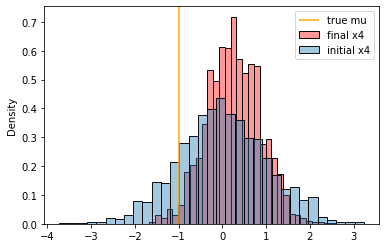

true x_5: tf.Tensor(-1.0, shape=(), dtype=float64) 
estimate: tf.Tensor(0.26025709348368337, shape=(), dtype=float64)


In [240]:
plot_hist(4, samples_plot, samples_plot_init)

### Compare with results from SMC

In [241]:
def loglik(x):
    loglik1 = tfd.Normal(loc=x[:, 0:1], scale=sigma).log_prob(obs[:, :1].T)
    loglik2 = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[:, 1:2].T)
    loglik3 = tfd.Normal(loc=x[:, 2:3], scale=sigma).log_prob(obs[:, 2:3].T)
    loglik = tf.reduce_sum(loglik1 + loglik2 + loglik3, axis=1, keepdims=True)
    return loglik

def logprior(x):
    logp1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 0:1])
    logp2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])   
    logp3 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 2:3])
    logp4 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 3:4])
    logprior5 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 4:5])
    return logp1 + logp2 + logp3 + logp4 + logprior5
    
def smc(seed):
    return tfp.experimental.mcmc.sample_sequential_monte_carlo(
        prior_log_prob_fn=logprior,
        likelihood_log_prob_fn=loglik,
        current_state=samples_init,
        seed=seed)[1]

In [242]:
smc_res = smc(seed=(12, 34))

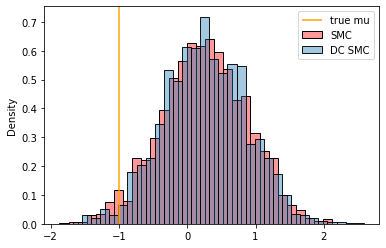

true x_5: tf.Tensor(-1.0, shape=(), dtype=float64) 
estimate: tf.Tensor(0.24412364001800466, shape=(), dtype=float64)
true x5: tf.Tensor(-1.0, shape=(), dtype=float64) 
HMC estimate: tf.Tensor(0.24412364001800466, shape=(), dtype=float64) 
DC SMC estimate: tf.Tensor(0.2543982868096866, shape=(), dtype=float64)


In [243]:
ind = 4
plot_hist(ind, smc_res, samples_plot, label1="SMC", label2="DC SMC")

print(
    f"true x{ind+1}:",
    x_true[0, ind],
    "\nHMC estimate:",
    tf.reduce_mean(smc_res[:, ind]),
    "\nDC SMC estimate:",
    weighted_sum(lambda x: x, samples_res[:, ind].reshape((-1, 1)), log_w)
)

# Change prior
$p_3(x_3) = \mathcal{N}(x_3; 0, \gamma^2) \rightarrow p_3(x_3) = \mathcal{N}(x_3; 0, 4\gamma^2)$

In [262]:
def log_gamma5_new(x):
    loglik1 = tfd.Normal(loc=x[:, 0:1], scale=sigma).log_prob(obs[:, :1].T)
    loglik2 = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[:, 1:2].T)
    loglik3 = tfd.Normal(loc=x[:, 2:3], scale=sigma).log_prob(obs[:, 2:3].T)
    loglik = tf.reduce_sum(loglik1 + loglik2 + loglik3, axis=1, keepdims=True)

    logp1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, :1])
    logp2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])   
    logp3 = tfd.Normal(loc=x[:, 4:5], scale=2 * gamma).log_prob(x[:, 2:3])
    logp4 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 3:4])
    logp5 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 4:5])
    return loglik + logp1 + logp2 + logp3 + logp4 + logp5

In [263]:
model_new = Model(log_gamma5_new, proposal, 4)
model_new.build_child(log_gamma4, proposal, 3, update=False)
model_new.build_child(log_gamma3, proposal, 2, update=False)
model_new.children[0].build_child(log_gamma2, proposal, 1, update=False)
model_new.children[0].build_child(log_gamma1, proposal, 0, update=False)

In [264]:
samples_res_new, log_w_new = dc_smc(samples_res, log_w, model_new)

In [265]:
samples_plot_new = tf.Variable(tf.identity(samples_res_new))
samples_plot_new = samples_plot_new[:, -1].assign(resample(log_w, samples_res_new[:, -1]))

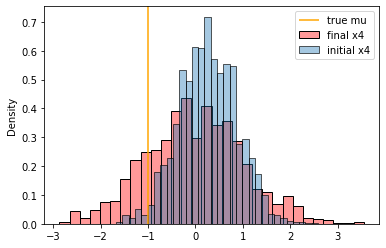

true x_5: tf.Tensor(-1.0, shape=(), dtype=float64) 
estimate: tf.Tensor(-0.018561855668159398, shape=(), dtype=float64)


In [266]:
plot_hist(4, samples_plot_new, samples_plot)

## Compare new samples with HMC

In [267]:
def logprior_new(x):
    logp1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 0:1])
    logp2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])   
    logp3 = tfd.Normal(loc=x[:, 4:5], scale=2 * gamma).log_prob(x[:, 2:3])
    logp4 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 3:4])
    logprior5 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 4:5])
    return logp1 + logp2 + logp3 + logp4 + logprior5

In [268]:
smc_res_new = tfp.experimental.mcmc.sample_sequential_monte_carlo(
    prior_log_prob_fn=logprior_new,
    likelihood_log_prob_fn=loglik,
    current_state=samples_init,
    seed=(12, 34))[1]

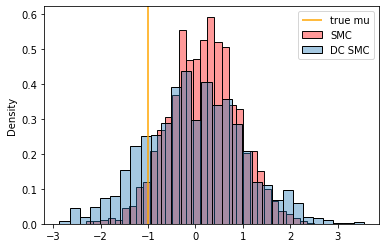

true x_5: tf.Tensor(-1.0, shape=(), dtype=float64) 
estimate: tf.Tensor(0.1699071379665767, shape=(), dtype=float64)
true x5: tf.Tensor(-1.0, shape=(), dtype=float64) 
HMC estimate: tf.Tensor(0.1699071379665767, shape=(), dtype=float64) 
DC SMC estimate: tf.Tensor(0.1788974981605391, shape=(), dtype=float64)


In [269]:
ind = 4
plot_hist(ind, smc_res_new, samples_plot_new, label1="SMC", label2="DC SMC")

print(
    f"true x{ind+1}:",
    x_true[0, ind],
    "\nHMC estimate:",
    weighted_sum(lambda x: x, smc_res_new[:, ind].reshape((-1, 1))),
    "\nDC SMC estimate:",
    weighted_sum(lambda x: x, samples_res_new[:, ind].reshape((-1, 1)), log_w_new)
)

# MCMC starting from a point in 

In [272]:
def log_target(x):
    return logprior(x) + loglik(x)

rw_kernel = tfp.mcmc.RandomWalkMetropolis(log_target)

In [320]:
mcmc_res = tf.identity(samples_init[:1, :])

prev_res = rw_kernel.bootstrap_results(mcmc_res)

In [321]:
prev_res

MetropolisHastingsKernelResults(
  accepted_results=UncalibratedRandomWalkResults(
      log_acceptance_correction=<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>,
      target_log_prob=<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-4345.05878504]])>,
      seed=[]
    ),
  is_accepted=<tf.Tensor: shape=(1, 1), dtype=bool, numpy=array([[ True]])>,
  log_accept_ratio=<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>,
  proposed_state=<tf.Tensor: shape=(1, 5), dtype=float64, numpy=array([[ 1.67829982, -0.78509377,  0.47839499,  0.23487219, -2.60861646]])>,
  proposed_results=UncalibratedRandomWalkResults(
      log_acceptance_correction=<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>,
      target_log_prob=<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-4345.05878504]])>,
      seed=<tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 0], dtype=int32)>
    ),
  extra=[],
  seed=<tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 0

In [322]:
nthin = 1
nburnin = 1000
mcmc_steps = nburnin + N * nthin
for t in range(mcmc_steps):
    next_sample, prev_res = rw_kernel.one_step(mcmc_res[-1, :].reshape((1, -1)), prev_res)
    mcmc_res = tf.concat([mcmc_res, next_sample], axis=0)
    
    if (t+1) % 100 == 0:
        print(f"[{t+1}/{mcmc_steps}]")

[100/3000]
[200/3000]
[300/3000]
[400/3000]
[500/3000]
[600/3000]
[700/3000]
[800/3000]
[900/3000]
[1000/3000]
[1100/3000]
[1200/3000]
[1300/3000]
[1400/3000]
[1500/3000]
[1600/3000]
[1700/3000]
[1800/3000]
[1900/3000]
[2000/3000]
[2100/3000]
[2200/3000]
[2300/3000]
[2400/3000]
[2500/3000]
[2600/3000]
[2700/3000]
[2800/3000]
[2900/3000]
[3000/3000]


(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([1.68173488, 1.6870428 , 1.69235073, 1.69765865, 1.70296657,
        1.70827449, 1.71358241, 1.71889033, 1.72419825, 1.72950618,
        1.7348141 ]),
 <a list of 2001 BarContainer objects>)

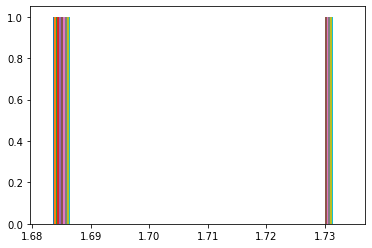

In [308]:
plt.hist(mcmc_res[nburnin:, 0])